In [1]:
import pandas as pd
import numpy as np
import mne
from mne.time_frequency import psd_array_welch
from pymatreader import read_mat
from matplotlib import pyplot as plt
import scipy.stats as stats
from scipy.stats import shapiro
import seaborn as sns
import pylab
import scipy
from itertools import product
from scipy.stats import iqr
import warnings
from mne import create_info
from mne.io import RawArray
from mne.viz.topomap import _add_colorbar
from mne.viz import plot_topomap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Functions

In [2]:
def plot_values_topomap(value_dict, montage, axes, mask, mask_params, colorbar=True, cmap='GnBu',
                        vmin=None, vmax=None, names=None, image_interp='linear', side_cb="right",
                        sensors=True, show_names=True, format='%2.1e', cbar_title='', **kwargs):
    if names is None:
        names = montage.ch_names

    info = create_info(names, sfreq=256, ch_types="eeg")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        RawArray(np.zeros((len(names), 1)), info, copy=None, verbose=False).set_montage(montage)

    im = plot_topomap([value_dict[ch] for ch in names], pos=info, show=False, image_interp=image_interp,
                      sensors=sensors, res=64, axes=axes, names=None, mask=mask, mask_params=mask_params, cmap=cmap, vlim=(vmin,vmax),**kwargs)

    if colorbar:
        try:
            cbar, cax = _add_colorbar(axes, im[0], cmap, pad=.05,
                                      format=format, side=side_cb)
            axes.cbar = cbar
            cbar.ax.tick_params(labelsize=14)
            cax.set_ylabel(cbar_title,fontsize=14)

        except TypeError:
            pass

    return im

In [3]:
def wilcox_stat_fun(x, y, axis=0):
    return 1/stats.wilcoxon(x,y,axis=axis)[0]

In [4]:
def get_channel_index_for_band(cluster, ind_band):
    return cluster[:,cluster[1]==ind_band][0]

## Reading in the psd_dfs dataframe

In [5]:
psd_dfs = pd.read_csv('/Users/lina_01/Desktop/ab_ica/psd_dfs.csv')
psd_dfs['log10_psd'] = np.log(psd_dfs['psd'])

bands_dict = {'delta':(2,4), 'theta':(4,6), 'low_alpha':(6,9), 'high_alpha':(9,13), 'beta':(13,30), 'gamma':(30,50)}
for band_name, band in bands_dict.items():
    psd_dfs.loc[(psd_dfs['freq']>=band[0]) & (psd_dfs['freq']<band[1]),'freq_band'] = band_name

## Topomap figures

In [6]:
montage = mne.channels.make_standard_montage("GSN-HydroCel-129")
info = mne.create_info(montage.ch_names, sfreq=500, ch_types='eeg')
raw = mne.io.RawArray(np.zeros([129,1]), info).set_montage(montage)
channel_names = montage.ch_names

Creating RawArray with float64 data, n_channels=129, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


In [7]:
adj_matrix = mne.channels.find_ch_adjacency(raw.info, ch_type='eeg')[0]
adj_matrix = mne.stats.combine_adjacency(adj_matrix, 6)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 129


In [8]:
threshold = 434

In [18]:
mask_params = dict(markersize=5, markerfacecolor="y")

### Eye movements

#### Cluster-based permutation analysis

In [10]:
psd_dfs_saccade = psd_dfs.loc[(psd_dfs['seg_type']=='saccade')]
psd_dfs_saccade_means = psd_dfs_saccade.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq','freq_band'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [25]:
tmp = psd_dfs_saccade_means.pivot_table(index=["subject_age", "channel", "seg_type", "freq_band"], columns="kind", values="log10_psd")
original_logs = tmp['original']
ab_logs = tmp['AB']
ica_logs =tmp['ICA']

diff_AB = (original_logs - ab_logs).abs()
diff_AB.name = "diff_psd"
diff_AB = diff_AB.reset_index()

diff_ICA = (original_logs - ica_logs).abs()
diff_ICA.name = "diff_psd"
diff_ICA = diff_ICA.reset_index()

X_saccade_ab_ica = []

for band in bands_dict.keys():
    psd_dfs_saccade_means_bands_ab = diff_AB.loc[(diff_AB['freq_band']==band)]
    psd_dfs_saccade_means_bands_ab = psd_dfs_saccade_means_bands_ab.pivot_table(index='subject_age', 
                                                                                columns='channel', values='diff_psd')
    psd_dfs_saccade_means_bands_ab = np.array(psd_dfs_saccade_means_bands_ab.loc[:, montage.ch_names])
    
    psd_dfs_saccade_means_bands_ica = diff_ICA.loc[(diff_ICA['freq_band']==band)]
    psd_dfs_saccade_means_bands_ica = psd_dfs_saccade_means_bands_ica.pivot_table(index='subject_age', 
                                                                                 columns='channel', 
                                                                                 values='diff_psd')
    psd_dfs_saccade_means_bands_ica = np.array(psd_dfs_saccade_means_bands_ica[montage.ch_names])

    X_saccade_ab_ica.append([psd_dfs_saccade_means_bands_ica, psd_dfs_saccade_means_bands_ab])

X_saccade_ab_ica = np.array(X_saccade_ab_ica).transpose([1,2,3,0])

In [12]:
X_saccade_ab_ica.shape

(2, 50, 129, 6)

In [13]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_saccade_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001570 max=0.007407
Running initial clustering …
Found 3 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Extracting significant channels to plot

In [23]:
bands = ['delta', 'theta', 'low_alpha', 'high_alpha', 'beta', 'gamma']

mask_dict = {}

for ind_band, band in enumerate(bands):
    significant_channels = []
    for cluster, p_val in zip(clusters, clusters_pv):   
        if p_val > 0.05:
            continue
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_band(cluster, ind_band)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[band] = mask

#### Calculating differences between AB and ICA for topomap

In [26]:
diff_AB_ICA = (diff_AB.set_index(["subject_age", "channel", "seg_type", "freq_band"]) - 
               diff_ICA.set_index(["subject_age", "channel", "seg_type", "freq_band"])).reset_index()
diff_AB_ICA = diff_AB_ICA.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_AB_ICA.groupby("freq_band")}


#### Plotting topomap

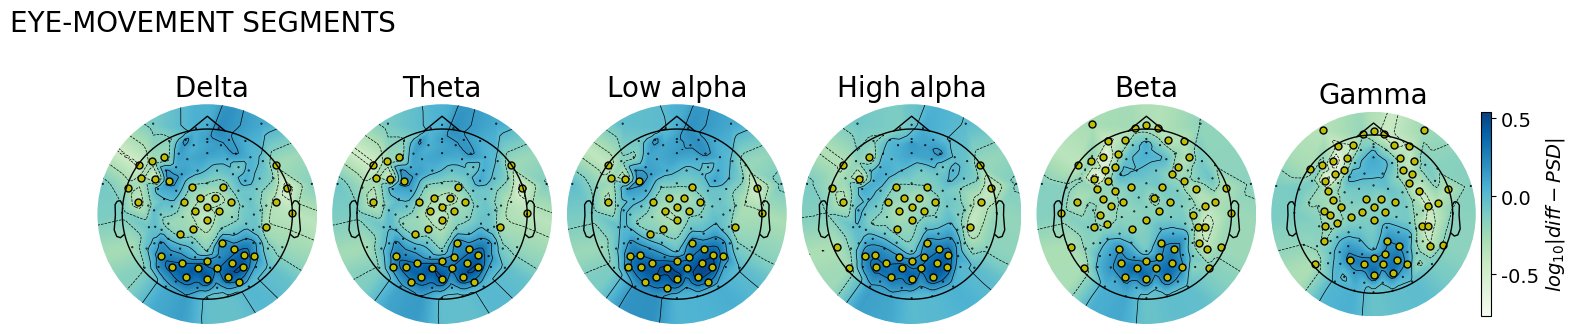

In [27]:
fig, axes = plt.subplots(1,6,figsize=(15,6))

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(axes, bands):
    plot_values_topomap(dict_topomaps[band], montage, ax, mask_dict[band], mask_params, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= band == "gamma", 
                        cbar_title='$log_{10}|diff-PSD|$')

axes[0].set_title('EYE-MOVEMENT SEGMENTS \n \n Delta',fontsize=20)
axes[1].set_title('Theta',fontsize=20)
axes[2].set_title('Low alpha',fontsize=20)
axes[3].set_title('High alpha',fontsize=20)
axes[4].set_title('Beta',fontsize=20)
axes[5].set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('figS1a.png', facecolor='white',bbox_inches='tight')

#### Plotting topomaps separately

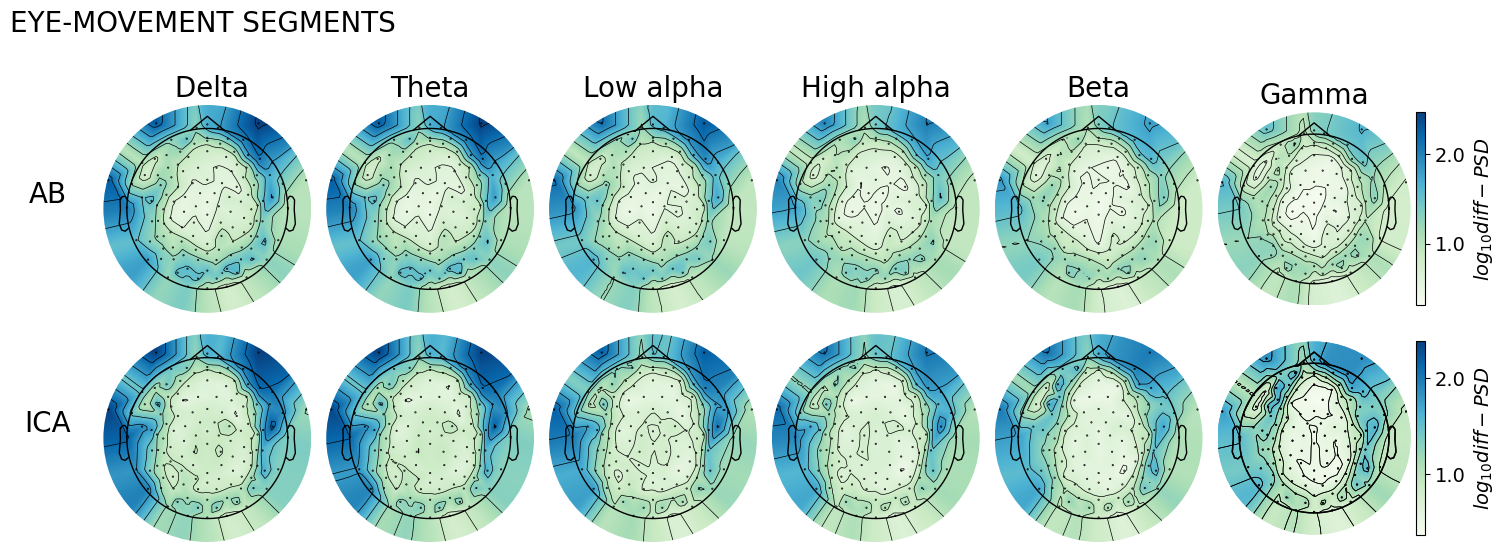

In [28]:
fig, axes = plt.subplots(2,6,figsize=(15,6))

diff_AB = (original_logs - ab_logs).abs()
diff_AB.name = "diff_psd"
diff_AB = diff_AB.reset_index()
diff_AB = diff_AB.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_AB.groupby("freq_band")}

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(list(range(5)),bands):
    plot_values_topomap(dict_topomaps[band], montage, axes[0][ax], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= False)
plot_values_topomap(dict_topomaps["gamma"], montage, axes[0][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= True, 
                        cbar_title='$log_{10}diff-PSD$')

diff_ICA = (original_logs - ica_logs).abs()
diff_ICA.name = "diff_psd"
diff_ICA = diff_ICA.reset_index()
diff_ICA = diff_ICA.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_ICA.groupby("freq_band")}

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(list(range(6)),bands):
    plot_values_topomap(dict_topomaps[band], montage, axes[1][ax], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= False)
plot_values_topomap(dict_topomaps["gamma"], montage, axes[1][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= True, cbar_title='$log_{10}diff-PSD$')


axes[0][0].set_title('EYE-MOVEMENT SEGMENTS \n \n Delta',fontsize=20)
axes[0][1].set_title('Theta',fontsize=20)
axes[0][2].set_title('Low alpha',fontsize=20)
axes[0][3].set_title('High alpha',fontsize=20)
axes[0][4].set_title('Beta',fontsize=20)
axes[0][5].set_title('Gamma',fontsize=20)

axes[0][0].set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
axes[1][0].set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')

fig.tight_layout()

plt.savefig('fig5a.png', facecolor='white',bbox_inches='tight')

### Clean

#### Cluster based permutation test

In [29]:
psd_dfs_clean = psd_dfs.loc[(psd_dfs['seg_type']=='clean')]
psd_dfs_clean_means = psd_dfs_clean.groupby(['subject_age', 'channel', 'kind', 'seg_type','freq','freq_band'])\
                                       .mean().reset_index().drop(columns='Unnamed: 0')

In [30]:
tmp = psd_dfs_clean_means.pivot_table(index=["subject_age", "channel", "seg_type", "freq_band"], columns="kind", values="log10_psd")
original_logs = tmp['original']
ab_logs = tmp['AB']
ica_logs =tmp['ICA']

diff_AB = (original_logs - ab_logs).abs()
diff_AB.name = "diff_psd"
diff_AB = diff_AB.reset_index()

diff_ICA = (original_logs - ica_logs).abs()
diff_ICA.name = "diff_psd"
diff_ICA = diff_ICA.reset_index()

X_clean_ab_ica = []

for band in bands_dict.keys():
    psd_dfs_clean_means_bands_ab = diff_AB.loc[(diff_AB['freq_band']==band)]
    psd_dfs_clean_means_bands_ab = psd_dfs_clean_means_bands_ab.pivot_table(index='subject_age', 
                                                                                columns='channel', values='diff_psd')
    psd_dfs_clean_means_bands_ab = np.array(psd_dfs_clean_means_bands_ab.loc[:, montage.ch_names])
    
    psd_dfs_clean_means_bands_ica = diff_ICA.loc[(diff_ICA['freq_band']==band)]
    psd_dfs_clean_means_bands_ica = psd_dfs_clean_means_bands_ica.pivot_table(index='subject_age', 
                                                                                 columns='channel', 
                                                                                 values='diff_psd')
    psd_dfs_clean_means_bands_ica = np.array(psd_dfs_clean_means_bands_ica[montage.ch_names])

    X_clean_ab_ica.append([psd_dfs_clean_means_bands_ica, psd_dfs_clean_means_bands_ab])

X_clean_ab_ica = np.array(X_clean_ab_ica).transpose([1,2,3,0])

In [31]:
w, clusters, clusters_pv, h0 = mne.stats.permutation_cluster_test(X_clean_ab_ica, threshold = 1/threshold, n_permutations=1000, 
                                                                  stat_fun=wilcox_stat_fun, adjacency=adj_matrix)

stat_fun(H1): min=0.001572 max=0.011628
Running initial clustering …
Found 5 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

#### Extracting significant channels to plot

In [32]:
bands = ['delta', 'theta', 'low_alpha', 'high_alpha', 'beta', 'gamma']

mask_dict = {}

for ind_band, band in enumerate(bands):
    significant_channels = []
    for cluster, p_val in zip(clusters, clusters_pv):   
        if p_val > 0.05:
            continue
        cluster = np.stack(cluster)
        channel_index = get_channel_index_for_band(cluster, ind_band)
        significant_channels.extend(channel_index)
        
    significant_channels = sorted(significant_channels)
    
    mask = np.zeros((129,),dtype='bool')
    for ch in significant_channels:
        mask[ch] = True
    mask_dict[band] = mask

#### Calculating differences between AB and ICA for topomap

In [33]:
diff_AB_ICA = (diff_AB.set_index(["subject_age", "channel", "seg_type", "freq_band"]) - 
               diff_ICA.set_index(["subject_age", "channel", "seg_type", "freq_band"])).reset_index()
diff_AB_ICA = diff_AB_ICA.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_AB_ICA.groupby("freq_band")}

#### Plotting topomap

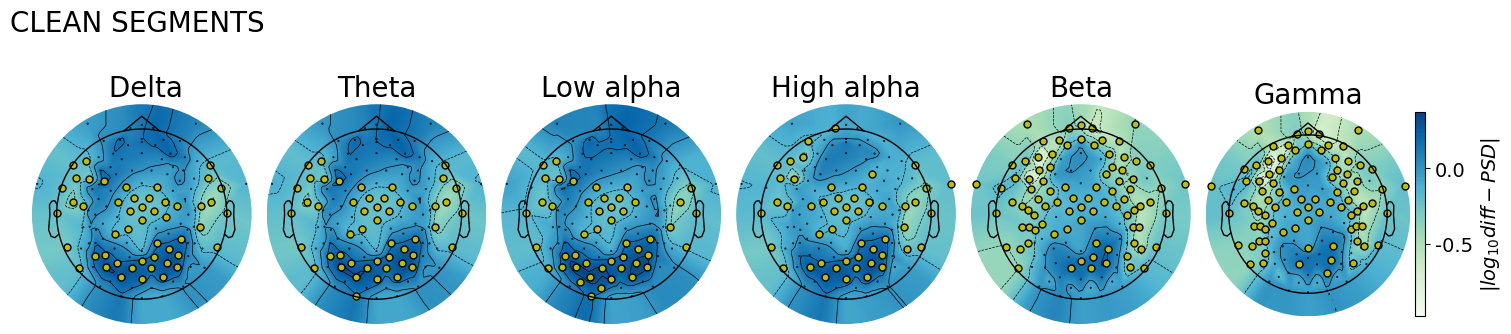

In [34]:
fig, axes = plt.subplots(1,6,figsize=(15,6))

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(axes, bands):
    plot_values_topomap(dict_topomaps[band], montage, ax, mask_dict[band], mask_params, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= band == "gamma", 
                        cbar_title='$|log_{10}diff-PSD|$')

axes[0].set_title('CLEAN SEGMENTS \n \n Delta',fontsize=20)
axes[1].set_title('Theta',fontsize=20)
axes[2].set_title('Low alpha',fontsize=20)
axes[3].set_title('High alpha',fontsize=20)
axes[4].set_title('Beta',fontsize=20)
axes[5].set_title('Gamma',fontsize=20)

fig.tight_layout()

plt.savefig('figS1b.png', facecolor='white',bbox_inches='tight')

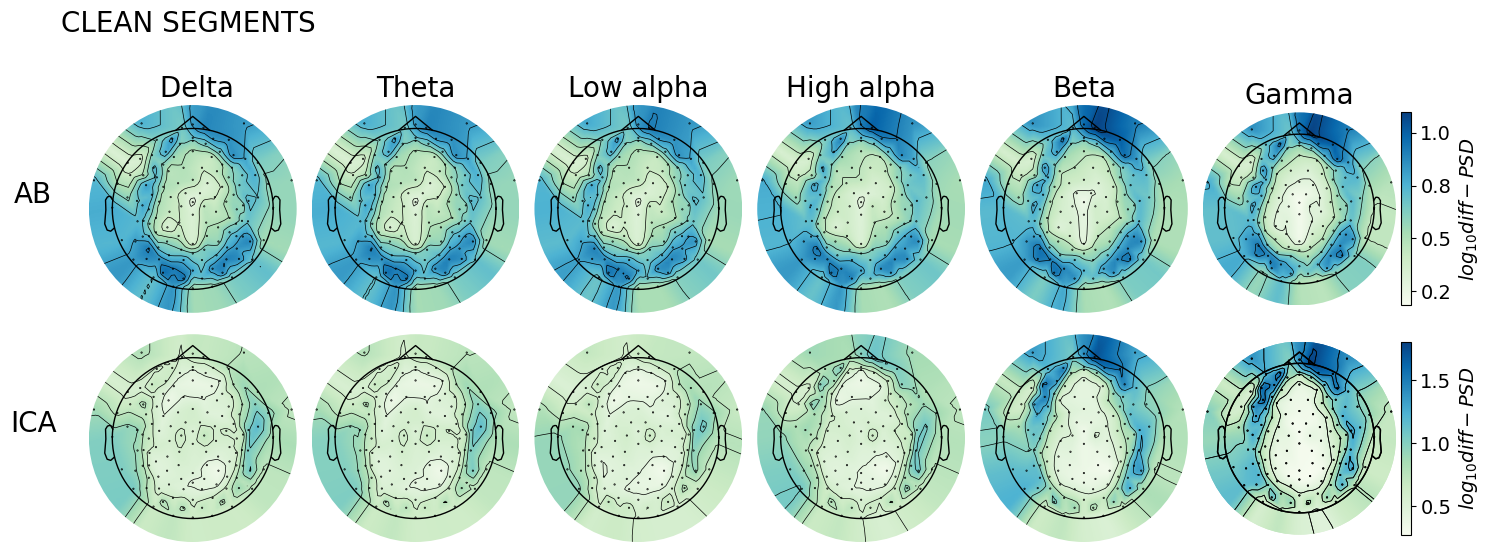

In [35]:
fig, axes = plt.subplots(2,6,figsize=(15,6))

diff_AB = (original_logs - ab_logs).abs()
diff_AB.name = "diff_psd"
diff_AB = diff_AB.reset_index()
diff_AB = diff_AB.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_AB.groupby("freq_band")}

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(list(range(5)),bands):
    plot_values_topomap(dict_topomaps[band], montage, axes[0][ax], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= False)
plot_values_topomap(dict_topomaps["gamma"], montage, axes[0][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= True, 
                        cbar_title='$log_{10}diff-PSD$')

diff_ICA = (original_logs - ica_logs).abs()
diff_ICA.name = "diff_psd"
diff_ICA = diff_ICA.reset_index()
diff_ICA = diff_ICA.drop(columns="subject_age").groupby(["channel", "seg_type", "freq_band"]).mean()

dict_topomaps = {band: df.reset_index(["seg_type", "freq_band"])["diff_psd"].to_dict() 
                 for band, df in diff_ICA.groupby("freq_band")}

vmins = []
vmaxes = []


for dict_topo in dict_topomaps.values():
    vmin = min(dict_topo.values())
    vmax = max(dict_topo.values())
    vmins.append(vmin)
    vmaxes.append(vmax)

vmin1 = min(vmins)
vmax1 = max(vmaxes)

for ax, band in zip(list(range(6)),bands):
    plot_values_topomap(dict_topomaps[band], montage, axes[1][ax], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= False)
plot_values_topomap(dict_topomaps["gamma"], montage, axes[1][5], mask=None, mask_params=None, names=channel_names, vmin=vmin1, 
                        vmax=vmax1,format='%2.1f', colorbar= True, cbar_title='$log_{10}diff-PSD$')

axes[0][0].set_title('CLEAN SEGMENTS \n \n Delta',fontsize=20)
axes[0][1].set_title('Theta',fontsize=20)
axes[0][2].set_title('Low alpha',fontsize=20)
axes[0][3].set_title('High alpha',fontsize=20)
axes[0][4].set_title('Beta',fontsize=20)
axes[0][5].set_title('Gamma',fontsize=20)

axes[0][0].set_ylabel('AB', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')
axes[1][0].set_ylabel('ICA', labelpad=40, rotation = 'horizontal',fontsize=20, loc='center')

fig.tight_layout()

plt.savefig('fig5b.png', facecolor='white',bbox_inches='tight')

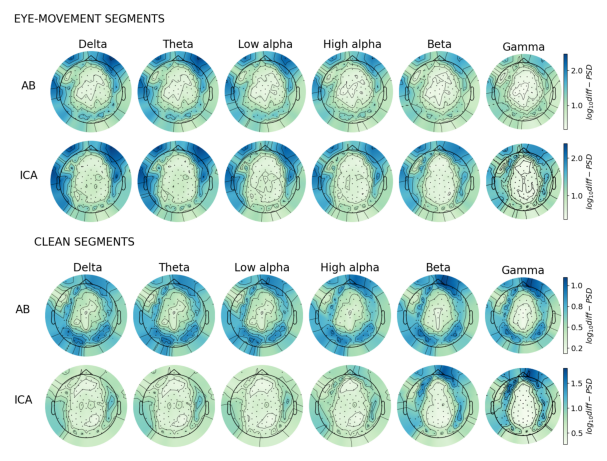

In [36]:
import matplotlib.image as mpimg
figures = ['5a','5b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(6, 4.6))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("fig5.png", dpi=300)

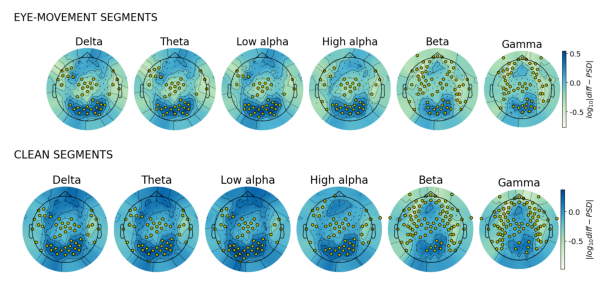

In [38]:
import matplotlib.image as mpimg
figures = ['S1a','S1b']
margin = 200
fig, axes = plt.subplots(2, 1, figsize=(6, 3))
for figure, ax in zip(figures, axes.ravel()):
    img = mpimg.imread(f"/Users/lina_01/Desktop/ab_ica/fig{figure}.png")
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set(frame_on=False)
    
    ax.imshow(img)        
    ax.set_aspect(1)    
    
fig.tight_layout(rect=[-0.01, -0.02, 1.02, 1.02], w_pad=0.0, h_pad=0.0)
fig.savefig("figS2.png", dpi=300)

In [ ]:
##EXTRA##

In [ ]:
ab_ica_pt_selection = pd.read_excel('/Users/lina_01/Desktop/ab_ica/AB_ICA_pt_table.xlsx'

In [ ]:
psd_dfs = []
kinds = ['original', 'AB', 'ICA']
seg_types = ['saccade', 'clean']
path = 'C:/Users/dsrish/Desktop/fieldtrip-20220208'
pts = list(ab_ica_pt_selection['pt'])

for kind in kinds:
    for pt in pts:
        annot_file = f'/Users/dsrish/Desktop/ds_msc_project/manual_annot_AB_ICA_{pt}.csv'
        for seg_type in seg_types:
            annotations = mne.read_annotations(annot_file)
            times = {}
            for annot in annotations:
                times['onset'] = np.array([annot['onset'] for annot in annotations if annot['description']==seg_type])
                times['duration'] = np.array([annot['duration'] for annot in annotations if annot['description']==seg_type])
                times['offset'] = times['onset'] + times['duration']

            crops = []
            for tmin, tmax in zip(times['onset'],times['offset']):
                if kind=='original':
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')           

                elif kind=='AB':
                    raw_file_original = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_processed.fif')
                    AB_mat_outdata = read_mat(f'{path}/{pt}_AB_outdata.mat')
                    AB_mat_outdata = AB_mat_outdata['datatosave_out']['OutData']
                    raw_file = mne.io.RawArray(AB_mat_outdata, raw_file_original.info)

                else:
                    raw_file = mne.io.read_raw_fif(f'{path}/{pt}_rest_raw_ica.fif')
                
                crop = raw_file.crop(tmin=tmin, tmax=tmax)
                crops.append(crop)

            crop_file = mne.concatenate_raws(crops)  

            srate = raw_file.info['sfreq']
            nfft = int(srate/2)
            nperseg = int(0.5*nfft)
            overlap = int(0.25 * nfft)
            psd, freq = psd_welch(crop_file, picks='all', fmin=2, fmax=48, n_fft=nfft, n_per_seg=nperseg, n_overlap=overlap, 
                                  average='mean')
            assert(not np.any(np.isnan(psd)))
            psd = pd.DataFrame(psd)
            psd['pt'] = pt
            psd['channel'] = crop_file.ch_names
            psd['seg_type'] = seg_type
            psd['kind'] = kind
            psd.columns.values[:len(freq)] = freq
            psd_long = pd.melt(psd, id_vars=['pt','channel', 'seg_type', 'kind'], value_vars=list(psd.columns))
            psd_dfs.append(psd_long)

In [ ]:
psd_dfs = pd.concat(psd_dfs)
psd_dfs.rename(columns={'variable':'freq', 'pt':'subject_age','value':'psd'}, inplace=True)

In [ ]:
np.any(np.isnan(psd_dfs.psd))